# **Exploratory Data Analysis**

Import Packages

In [2]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import nasdaqdatalink

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, BaggingRegressor
)
import xgboost as xgb
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#--- Starting Here ---#

In [3]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [4]:
NVDA = 'NVDA'
SEMICONDUCTORS = ["TSM", "AVGO", "AMD", "ASML", "MRVL", "ON"]
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaling RSI values for more relatable trends

semiConductor_data = yf.download(NVDA, start='2010-01-01', end='2024-01-01')
semiConductor_data.columns = [col[0] for col in semiConductor_data.columns]
semiConductor_data['Ticker'] = NVDA
semiConductor_data['RSI'] = calculate_rsi(semiConductor_data['Close'], window=14)
semiConductor_data['RSI_Scaled'] = scaler.fit_transform(semiConductor_data['RSI'].values.reshape(-1, 1))
semiConductor_data.reset_index(inplace=True)
semiConductor_data = semiConductor_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]

#print(f"Total Data Length: {len(semiConductor_data)}")

for stock in SEMICONDUCTORS:
    stock_data = yf.download(stock, start="2010-01-01", end="2024-01-01")

    stock_data['Ticker'] = stock
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)
    stock_data['RSI_Scaled'] = scaler.fit_transform(stock_data['RSI'].values.reshape(-1, 1))
    stock_data.reset_index(inplace=True)
    #stock_data = stock_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]
    stock_data.columns = [col[0] for col in stock_data.columns]

    semiConductor_data = pd.concat([stock_data, semiConductor_data], ignore_index=True)

    #print([val[0] for val in semiConductor_data.columns.tolist()])
    #print(f"Total Data Length: {len(semiConductor_data)}")

semiConductor_data = semiConductor_data.dropna()
semiConductor_data.to_csv("semiconductorData.csv", index=False)
print([ i for i in semiConductor_data['Ticker'].unique()])
for stock in SEMICONDUCTORS + [NVDA]:
    print(f"{stock} rows: {len(semiConductor_data.loc[semiConductor_data['Ticker'] == stock])}")

print(semiConductor_data.columns)
semiConductor_data.drop(columns=['Date'], inplace=True)
print(semiConductor_data.dtypes)
semiConductor_data.head(5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['ON', 'MRVL', 'ASML', 'AMD', 'AVGO', 'TSM', 'NVDA']
TSM rows: 3509
AVGO rows: 3509
AMD rows: 3509
ASML rows: 3509
MRVL rows: 3509
ON rows: 3509
NVDA rows: 3509
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled'], dtype='object')
Close         float64
High          float64
Low           float64
Open          float64
Volume          int64
Ticker         object
RSI           float64
RSI_Scaled    float64
dtype: object


,Close,High,Low,Open,Volume,Ticker,RSI,RSI_Scaled
13,7.67,8.06,7.62,8.06,13017500,ON,21.962626,0.179946
14,7.92,8.02,7.74,7.76,10853300,ON,30.125530,0.265726
15,7.88,7.96,7.74,7.85,7781900,ON,30.638304,0.271114
16,7.94,8.01,7.75,7.88,8462600,ON,29.130450,0.255269
17,7.44,7.99,7.29,7.99,20256200,ON,24.014345,0.201507


In [29]:
class lstmDataset(Dataset):
    def __init__(self, data, features, targets, input_window=20, output_window=10):
        self.data = torch.FloatTensor(data.values)
        self.input_window = input_window
        self.output_window = output_window
    
    def __len__(self):
        return len(self.data) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_window]
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window, 6]  # Assuming column 7 is the target
        return x, y

In [19]:
features = ["Close", "High", "Low", "Open", "Volume"]
targets = ["RSI_Scaled"]

company_datasets = {}
tickers = semiConductor_data['Ticker'].unique()

# Create an lstmDataset for each company and store it in company_datasets
for ticker in tickers:
    data = semiConductor_data[semiConductor_data['Ticker'] == ticker].drop(columns=["Ticker"])
    company_datasets[ticker] = lstmDataset(data, input_window=20, output_window=10, features=features, targets=targets)
print(company_datasets)

batch_size = 32 
company_loaders = {}

for ticker, dataset in company_datasets.items():
    company_loaders[ticker] = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(company_loaders)

{'ON': <__main__.lstmDataset object at 0x0000027CF1386840>, 'MRVL': <__main__.lstmDataset object at 0x0000027CFF0AA960>, 'ASML': <__main__.lstmDataset object at 0x0000027CFF0B3200>, 'AMD': <__main__.lstmDataset object at 0x0000027CFF0A63C0>, 'AVGO': <__main__.lstmDataset object at 0x0000027CFF0A30B0>, 'TSM': <__main__.lstmDataset object at 0x0000027C919C2CC0>, 'NVDA': <__main__.lstmDataset object at 0x0000027CFEC8E300>}
{'ON': <torch.utils.data.dataloader.DataLoader object at 0x0000027CF1309D60>, 'MRVL': <torch.utils.data.dataloader.DataLoader object at 0x0000027CFF09DD00>, 'ASML': <torch.utils.data.dataloader.DataLoader object at 0x0000027CFDD182F0>, 'AMD': <torch.utils.data.dataloader.DataLoader object at 0x0000027CFEDF0470>, 'AVGO': <torch.utils.data.dataloader.DataLoader object at 0x0000027CFF0B01D0>, 'TSM': <torch.utils.data.dataloader.DataLoader object at 0x0000027CFF0ABBF0>, 'NVDA': <torch.utils.data.dataloader.DataLoader object at 0x0000027CF15FB920>}


Define LSTM Model

In [30]:
class LSTMRegressionModel(nn.Module):
    def __init__(self, input_size, output_size, dropout=0.2):
        super(LSTMRegressionModel, self).__init__()
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=input_size, 
                             hidden_size=64, 
                             batch_first=True, 
                             dropout=dropout)
        
        self.lstm2 = nn.LSTM(input_size=64, 
                             hidden_size=128, 
                             batch_first=True, 
                             dropout=dropout)

        self.lstm3 = nn.LSTM(input_size=128, 
                             hidden_size=64, 
                             batch_first=True, 
                             dropout=dropout)
        
        # Fully connected layers
        self.dense1 = nn.Linear(64, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, output_size)
        
        # Activation functions and dropout
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.15)
        
    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        out = self.relu(out)

        out, _ = self.lstm2(out)
        out = self.relu(out)

        out, (hn, _) = self.lstm3(out)  # Use the hidden state from the last LSTM
        out = self.relu(out)
        
        # Fully connected layers
        out = hn[-1]  # Final hidden state from the last LSTM layer
        out = self.dense1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.dense2(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.dense3(out)  # Linear output for regression
        
        return out

In [32]:
epochs = 6
model = LSTMRegressionModel(input_size=7, output_size=10) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.MSELoss() # This is fine for a regression problem from a 0 - 1 range

for ticker, loader in company_loaders.items(): # Key Value type shit
    for epoch in range(epochs):
        for batch_idx, (x_batch, y_batch) in enumerate(loader):
            #print(len(x_batch[0][0]))
            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Company: {ticker}, Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

c:\Users\lordw\OneDrive\Documents\Coding_Projects\AlgoTrAdInG\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Company: ON, Epoch: 0, Batch: 0, Loss: 0.2569963335990906
Company: ON, Epoch: 0, Batch: 100, Loss: 0.04086890071630478
Company: ON, Epoch: 1, Batch: 0, Loss: 0.04130784794688225
Company: ON, Epoch: 1, Batch: 100, Loss: 0.033955853432416916
Company: ON, Epoch: 2, Batch: 0, Loss: 0.03315970301628113
Company: ON, Epoch: 2, Batch: 100, Loss: 0.06450843811035156
Company: ON, Epoch: 3, Batch: 0, Loss: 0.027277108281850815
Company: ON, Epoch: 3, Batch: 100, Loss: 0.03189463168382645
Company: ON, Epoch: 4, Batch: 0, Loss: 0.03422979637980461
Company: ON, Epoch: 4, Batch: 100, Loss: 0.039440859109163284
Company: ON, Epoch: 5, Batch: 0, Loss: 0.0296607818454504
Company: ON, Epoch: 5, Batch: 100, Loss: 0.03791889548301697
Company: MRVL, Epoch: 0, Batch: 0, Loss: 0.029758885502815247
Company: MRVL, Epoch: 0, Batch: 100, Loss: 0.026848291978240013
Company: MRVL, Epoch: 1, Batch: 0, Loss: 0.029223540797829628
Company: MRVL, Epoch: 1, Batch: 100, Loss: 0.030459102243185043
Company: MRVL, Epoch: 2, Ba

Test Loss after 100 batches: 0.033706211932003495
Average Test Loss: 0.03344621606717963
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(32, 10)
(32, 10)
Predictions for NVDA: [0.5341897  0.53407514 0.52892786 0.5307972  0.5299128  0.5252712
 0.52845687 0.52447855 0.52775496 0.525178  ]
True values for NVDA: [0.5766716  0.7353365  0.7339897  0.87075716 0.89704496 0.8978394
 0.91612536 0.91335654 0.89112777 0.87645084]


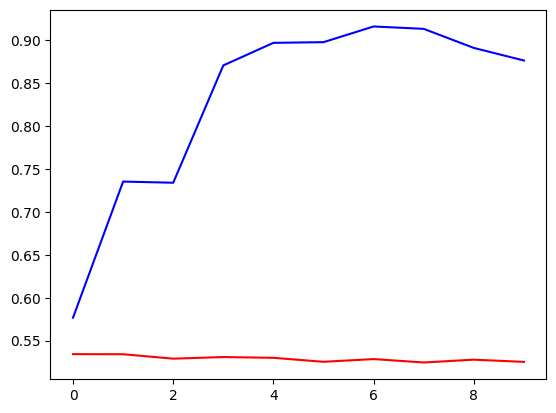

(32, 10)
(32, 10)
Predictions for NVDA: [0.5341897  0.53407514 0.52892786 0.5307972  0.5299128  0.5252712
 0.52845687 0.52447855 0.52775496 0.525178  ]
True values for NVDA: [0.32826948 0.33626935 0.3454896  0.32439974 0.40307206 0.36271635
 0.4260123  0.49684644 0.63967276 0.6310761 ]


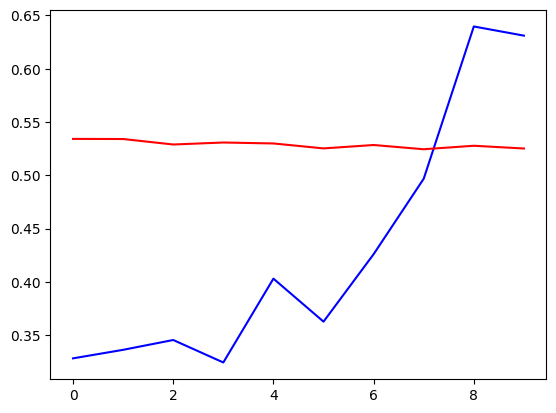

(32, 10)
(32, 10)
Predictions for NVDA: [0.5341897  0.53407514 0.52892786 0.5307972  0.5299128  0.5252712
 0.52845687 0.52447855 0.52775496 0.525178  ]
True values for NVDA: [0.4323417  0.35968384 0.4235245  0.58303916 0.5734985  0.4338899
 0.33970758 0.3836676  0.37853765 0.40021712]


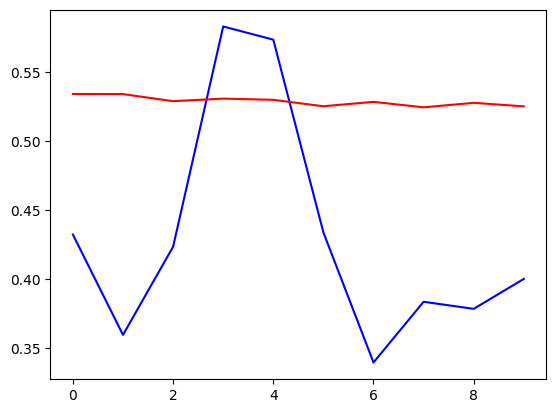

In [36]:
model.eval()
test_loss = 0
num_batches = 0

with torch.no_grad():
    i = 0
    for ticker, loader in company_loaders.items():
        i += 1
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            num_batches += 1
            
            if num_batches % 100 == 0:
                print(f"Test Loss after {num_batches} batches: {test_loss / num_batches}")
        if i == 1:
            break
        
# Calculate average test loss
avg_test_loss = test_loss / num_batches
print(f"Average Test Loss: {avg_test_loss}")

coordinates = np.linspace(start=0, stop=9, num=10, dtype=int).tolist()
print(coordinates)

ticker = "NVDA"  # Example: test for NVIDIA
j = 0
for x_batch, y_batch in company_loaders[ticker]:
    j += 1
    y_pred = model(x_batch)
    
    y_pred = y_pred.detach().numpy()
    y_batch = y_batch.numpy()
    print(y_batch.shape)
    print(y_pred.shape)
    print(f"Predictions for {ticker}: {y_pred[0]}")
    print(f"True values for {ticker}: {y_batch[0]}")
    plt.plot(coordinates, y_batch[0], color="blue")
    plt.plot(coordinates, y_pred[0], color="red")
    plt.show()
    if j == 3:
        break